# Reconstructing flow data

Just take the protein data.

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.optimize import minimize, nnls, LinearConstraint, lsq_linear
from scipy.linalg import lstsq
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sparse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [3]:
htec_data_path = '/data_volume/ifn_hbec/'
fig_path = '/data/home/Github/compressed_flow/figures/'
data_path = '/data_volume/compressed_flow/'

In [4]:
%matplotlib inline

### Read the full data

In [5]:
adata = sc.read(htec_data_path + 'HBEC_condition_assigned_deep.h5ad')
adata = adata[adata.obs.condition != 'unassigned'].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.obs['donor'] = adata.obs['condition'].apply(lambda x: x.split('_')[0])
adata.obs['stim'] = adata.obs['condition'].apply(lambda x: x.split('_')[1])
adata.obs['time'] = adata.obs['condition'].apply(lambda x: x.split('_')[2] if 'control' not in x else 0)

In [7]:
adata.shape

(80654, 36741)

### Slice out mRNA from ADT

In [8]:
adt_adata = adata[:, adata.var.query('feature_types == "Antibody Capture" & ~gene_ids.str.contains("hash").values').index].copy()
rna_adata = adata[:, adata.var.query('feature_types != "Antibody Capture"').index].copy()

In [9]:
rna_adata.shape

(80654, 36601)

### Take the filtered cell list from RNA data

In [10]:
filtered_rna_adata = sc.read(htec_data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [11]:
cell_list = filtered_rna_adata.obs.index.tolist()

### Filter the ADT data

In [12]:
filtered_adt_adata = adt_adata[cell_list, :].copy()

### Save the filtered ADT data

In [13]:
filtered_adt_adata.write(data_path + 'htec_filtered_adt.h5ad')

... storing 'donor' as categorical
... storing 'stim' as categorical
... storing 'time' as categorical


In [14]:
M = filtered_adt_adata[:, :99].X.toarray()

### Quick PCA, check variance explained

In [15]:
from sklearn.decomposition import PCA

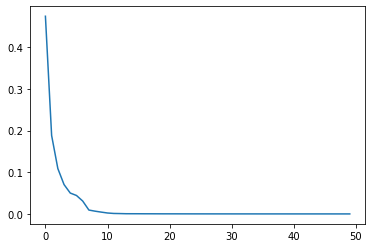

In [16]:
pca = PCA(n_components=50)
pca.fit(M)
plt.plot(pca.explained_variance_ratio_)

### Remove some outliers from true matrix

In [17]:
M = np.clip(M, a_min=None, a_max=600)

### Try ALS

Start with the normalized array

In [18]:
scaler = StandardScaler()
M_norm = scaler.fit_transform(M)

In [19]:
num_genes = M.shape[1]
num_cells = M.shape[0]
num_markers = 40
rank=30

In [20]:
P = np.random.choice([0, 1], size=(num_genes, num_markers), p=[1./4, 3./4])
P = P/P.sum(axis=1).reshape(-1, 1)

In [21]:
D = M@P
D_vec = D.reshape(-1)
print('Size of the true protein matrix M is', M.shape)
print('Size of the measured protein matrix D (measuring the linear combinations) is', D.shape)

Size of the true protein matrix M is (69958, 99)
Size of the measured protein matrix D (measuring the linear combinations) is (69958, 40)


In [22]:
D.sum()

50984881.00000001

In [23]:
M.sum()

50984876.0

### Alternating least squares

In [24]:
L_current = np.random.randn(num_cells,rank)*2+10
R_current = np.random.randn(rank,num_genes)*2+10

In [25]:
ridge = ElasticNet(positive=True, l1_ratio=0.01, max_iter=500000, alpha=1)

In [26]:
# def solve_L(R_current):
    
#     A = P.T@R_current.T
#     return np.apply_along_axis(lambda row: nnls(A, row)[0], axis=1, arr=D)

def solve_L(R_current):
    
    A = P.T@R_current.T
    model = ridge.fit(A, D.T)
    return model.coef_
#     return np.apply_along_axis(lambda row: ridge.fit(A, row.reshape(-1,1)).coef_, axis=1, arr=D)

In [27]:
P_pinv = np.linalg.pinv(P)

def solve_R(L_current):

    temp = np.linalg.pinv(L_current)@D@P_pinv
    temp[temp < 0] = np.random.random()/10
    return temp

In [28]:
%%time
# u_error = []
# v_error = []
D_vec = D.reshape(-1)
for i in range(20):
    if i % 2 == 0:
        print('Iter', i)
    L_current = solve_L(R_current)
    R_current = solve_R(L_current)
    
#     L_current = np.clip(L_current, a_min=-np.inf, a_max=np.quantile(L_current, 0.98))
#     R_current = np.clip(R_current, a_min=-np.inf, a_max=np.quantile(R_current, 0.98))
            

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Iter 18
CPU times: user 3min 8s, sys: 1.3 s, total: 3min 9s
Wall time: 2min 36s


In [29]:
M_fitted = L_current@R_current
M_fitted_norm = scaler.fit_transform(M_fitted)

### How well do we do

In [30]:
a = R_current.reshape(-1)
b = L_current.reshape(-1)

In [31]:
a[a < 20].shape

(1519,)

In [32]:
a.shape

(2970,)

In [33]:
corrs = []
inters = []
coefs = []
for col in range(M.shape[1]):
    a = M[:, col]
    b = M_fitted[:, col]
    
#     high_idx = a > 0
    
#     a = a[high_idx]
#     b = b[high_idx]
    s, inter, r, _, _ = stats.linregress(a,b)
    inters.append(inter)
    coefs.append(s)
    corrs.append(r)
coefs = np.array(coefs)
inters = np.array(inters)
corrs = np.array(corrs)

In [34]:
# weird_idx = (a <10) & (b > 100)

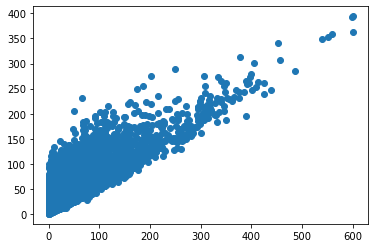

In [35]:
col = 20
a = M[:, col]
b = M_fitted[:, col]
plt.scatter(a,b)


In [36]:
np.array(corrs).mean()

0.6491959097644797

Text(0.5, 1.0, 'Correlations between actual and reconstructed protein expression')

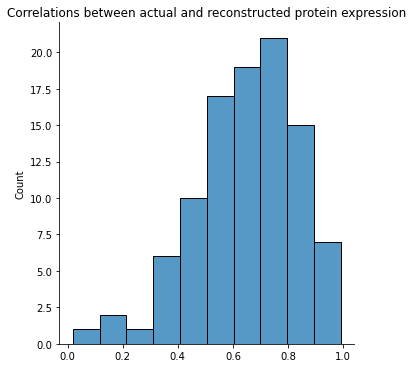

In [37]:
sns.displot(corrs)
plt.title('Correlations between actual and reconstructed protein expression')